# Análisis de Grandes Volúmenes de Datos
### Actividad 3 | Aprendizaje supervisado y no supervisado

Estudiante:

+ Eduardo Selim Martínez Mayorga - A01795167

In [1]:
#Descargamos las librerias necesarias, iniciamos sesion de Pyspark y cargamos la base de datos
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import countDistinct, count, isnan, when, desc, concat_ws, monotonically_increasing_id
from pyspark.sql.functions import col, expr, mean, stddev, min, max, length, ceil, floor
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, NumericType
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("CSVRead").getOrCreate()
df = spark.read.csv("Iowa_Liquor_Sales.csv", header=True, inferSchema=True)

25/05/25 20:30:44 WARN Utils: Your hostname, MacBook-Air-de-Eduardo.local resolves to a loopback address: 127.0.0.1; using 192.168.0.19 instead (on interface en0)
25/05/25 20:30:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/25 20:30:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/25 20:31:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# Cambiamos los nombres de las columnas para facilitar su manejo al programar
df = df.withColumnsRenamed({"Invoice/Item Number": "invoice_number",
"Date": "date",
"Store Number": "store_number",
"Store Name": "store_name",
"Address": "address",
"City": "city",
"Zip Code": "zip_code",
"Store Location": "store_location",
"County Number": "county_number",
"County": "county",
"Category": "category",
"Category Name": "category_name",
"Vendor Number": "vendor_number",
"Vendor Name": "vendor_name",
"Item Number": "item_number",
"Item Description": "item_description",
"Pack": "pack",
"Bottle Volume (ml)": "bottle_volume",
"State Bottle Cost": "bottle_cost",
"State Bottle Retail": "bottle_retail",
"Bottles Sold": "bottles_sold",
"Sale (Dollars)": "sale_dollars",
"Volume Sold (Liters)": "liters_sold",
"Volume Sold (Gallons)": "gallons_sold"})

## Parte 2: Selección de los datos

En esta parte se utilizará la rutina de la actividad pasada para construir un subconjunto de trabajo del 0.5% del dataset original (2 millones de datos aproximadamente) utilizando el criterio de estratificación basado en la categoría del producto (`category`) y el vendedor del producto (`vendor_number`).

In [4]:
# Variables de caracterización
vars_caracterizacion = ["category","vendor_number"]

# Total de filas para calcular proporciones
total = df.count()

# Agrupar por combinaciones y contar ocurrencias
df_grouped = df.groupBy(vars_caracterizacion).agg(count("*").alias("conteo"))

# Calcular probabilidad de cada combinación
df_prob = df_grouped.withColumn("probabilidad", col("conteo") / total)

# Conteo nos dice cuantas veces se repite una combinacion
# Probabilidad indica la probabilidad que hay de que salga dicha combinación
# Mostrar ejemplo de combinaciones y sus probabilidades
df_prob = df_prob.orderBy(desc("probabilidad"))

# Creamos la etiqueta del estrato concatenando el número de categoría y el número de vendedor con un guion de por medio
df_estrato = df_prob.select(concat_ws('_',df_prob.category,df_prob.vendor_number).alias("estrato"),
                            "category", "vendor_number", "conteo", "probabilidad")

# Creamos la etiqueta del estrato en el dataset completo
# concatenando el número de categoría y el número de vendedor con un guion de por medio
df = df.withColumn("estrato", concat_ws('_',df.category,df.vendor_number))

# Se define la proporción de la población que se requiere muestrear
prop_poblacion = 0.005

# Se obtiene el tamaño total de la muestra
n = math.ceil(total*prop_poblacion)

# Se obtiene una columna con el tamaño de muestra requerido de cada estrato
df_estrato = df_estrato.withColumn("muestra", col("probabilidad") * n)
df_estrato = df_estrato.withColumn("tamanio_muestra", ceil("muestra"))
df_estrato = df_estrato.withColumn("proporcion_estrato", col("tamanio_muestra")/col("conteo"))

# Se convierte el spark DataFrame en Pandas dataframe para extraer la proporción por estratos a muestrear
pandas_estratos = df_estrato.toPandas()

# Se construye un diccionario con la proporción a muestrear requerida en cada estrato
proporciones = pandas_estratos.set_index('estrato')['proporcion_estrato'].to_dict()

# RESULTADO FINAL
# Se obtiene la muestra por cada estrato del tamaño adecuado
muestra_df = df.sampleBy(col = "estrato", fractions = proporciones, seed = 5)

# Se obtiene el tamaño total del dataset
n_dataset = muestra_df.count()

Después del proceso de muestreo estratificado, el número de observaciones en el dataset de trabajo es

In [5]:
n_dataset

132264

A continuación se muestra un breve extracto del dataset de trabajo para esta actividad

In [6]:
muestra_df.show(3)

+--------------+----------+------------+--------------------+---------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+
|invoice_number|      date|store_number|          store_name|        address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato|
+--------------+----------+------------+--------------------+---------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+---

In [7]:
# Le generamos un id a cada observación (renglón)
muestra_df = muestra_df.withColumn('id', monotonically_increasing_id())

Adicionalmente, se seleccionará como variable objetivo para aprendizaje supervisado al precio del producto (`sale_dolars`) y como variables explicativas al volumen de la botella (`bottle_volumen`), el costo de la botella (`bottle_cost`), el número de botellas vendidas (`bottles_sold`), litros vendidos (`liters_sold`) como numéricas y a la categoría del producto (`category`) y tipo de empaque (`pack`) como categóricas

In [8]:
variable_objetivo = "sale_dollars"
explicativas_numericas = ["bottle_volume", "bottle_cost", "bottles_sold", "liters_sold"]
explicativas_categoricas = ["category", "pack"]

## Parte 3: Preparación de los datos

In [9]:
# Corrección de datos faltantes para variables categóricas
## Se calcula la moda para las varaibles categóricas
mode_category1 = muestra_df.groupBy("category").agg(count("*").alias("count")).orderBy(col("count").desc()).first()["category"]
mode_category2 = muestra_df.groupBy("pack").agg(count("*").alias("count")).orderBy(col("count").desc()).first()["pack"]

## Se completan los datos faltantes de las variables categóricas con las modas
muestra_df = muestra_df.withColumn("category", when(col("category").isNull(), mode_category1).otherwise(col("category")))
muestra_df = muestra_df.withColumn("pack", when(col("pack").isNull(), mode_category2).otherwise(col("pack")))

muestra_df.show(2)

25/05/25 20:37:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+
|invoice_number|      date|store_number|          store_name|      address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|
+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+-

In [10]:
# Se completan los datos numéricos faltantes
imputer = Imputer(inputCols = explicativas_numericas,
                  outputCols = explicativas_numericas)

imputer = imputer.fit(muestra_df)

muestra_df = imputer.transform(muestra_df)

In [11]:
# Generamos el objeto con las variables explicativas numéricas
vector_assembler_numerico = VectorAssembler(inputCols = explicativas_numericas,
                                            outputCol = 'explicativas_numericas_vector')

muestra_df = vector_assembler_numerico.transform(muestra_df)

In [12]:
# A las varibles categóricas primero las representaremos mediante un índice único y posteriormente se le aplicará one-hot encoding

## Se representa a las categorías de las variables categóricas como índices únicos
indexers = [
    StringIndexer(inputCol = c, outputCol = "{0}_index".format(c))
    for c in explicativas_categoricas
]

## Se aplica one-hot encoding a cada una de las variables categóricas
encoders = [
    OneHotEncoder(
        inputCol = indexer.getOutputCol(),
        outputCol = "{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

## Generamos el objeto con las variables explicativas categóricas
assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol = "explicativas_categoricas_vector"
)

pipeline = Pipeline(stages = indexers + encoders + [assembler])
pipeline = pipeline.fit(muestra_df)

muestra_df = pipeline.transform(muestra_df)

muestra_df.show(2)

+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+
|invoice_number|      date|store_number|          store_name|      address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categoricas_vector|
+--------------+----------+------------+--------------

## Parte 4. Preparación del conjunto de entrenamiento y prueba

Se aplicará la misma lógica de muestreo estratificado para hacer la construcción de los conjuntos de entrenamiento (`train`) y de prueba (`test`) del 70% y 30%, respectivamente.

In [13]:
## Para crear la muestra de entrenamiento y prueba

## Se definen las proporciones para el muestreo estratificado
df_conteo_train = muestra_df.groupBy("estrato").agg(count("*").alias("conteo"))
df_estrato_train = df_estrato.select("estrato", "probabilidad")
df_estrato_train = df_estrato_train.join(df_conteo_train, ['estrato'], "inner")

## Se especifica el tamaño del conjunto de entrenamiento (70%)
n_train = math.ceil(0.7 * n_dataset)

## Se obtiene una columna con el tamaño de muestra requerido de cada estrato en la muestra de entrenamiento
df_estrato_train = df_estrato_train.withColumn("muestra_train", col("probabilidad") * n_train)
df_estrato_train = df_estrato_train.withColumn("tamanio_muestra_train", floor("muestra_train"))
df_estrato_train = df_estrato_train.withColumn("prop_estrato_train", col("tamanio_muestra_train")/col("conteo"))

# Se convierte el spark DataFrame en Pandas dataframe para extraer la proporción por estratos a muestrear
pandas_estratos_train = df_estrato_train.toPandas()
pandas_estratos_train["prop_estrato_train"] = pandas_estratos_train["prop_estrato_train"].clip(upper=1.)

# Se construye un diccionario con la proporción a muestrear requerida en cada estrato en la muestra de entrenamiento
proporciones_train = pandas_estratos_train.set_index('estrato')['prop_estrato_train'].to_dict()

# Se obtiene el conjunto de entrenamiento con el tamaño para cada estrato del tamaño adecuado
train = muestra_df.sampleBy(col = "estrato", fractions = proporciones_train, seed = 5)
num_train = train.count()

# Se obtiene el conjunto de prueba como todo lo que está en el dataset de trabajo pero NO en el conjunto de entrenamiento
test = muestra_df.join(train, ['id'], "leftanti")
num_test = test.count()

El tamaño de los dataset de trabajo, entrenamiento y prueba, respectivamente son:

In [14]:
print(n_dataset)
print(num_train)
print(num_test)

132264
91679
40585


In [15]:
# Se muestra un extracto del dataset de prueba
test.show(3)

+----+--------------+----------+------------+--------------------+-----------------+----------+--------+--------------------+-------------+---------+--------+------------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+
|  id|invoice_number|      date|store_number|          store_name|          address|      city|zip_code|      store_location|county_number|   county|category|     category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categoricas_vector|
+----+--------------+----------+

In [16]:
# Se muestra un extracto del dataset de entrenamiento
train.show(3)

+--------------+----------+------------+--------------------+-------------------+-----------+--------+--------------------+-------------+----------+--------+-----------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+
|invoice_number|      date|store_number|          store_name|            address|       city|zip_code|      store_location|county_number|    county|category|    category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categoricas_vector|
+--------------+----------+-

In [17]:
# Estandarizamos las variables numéricas para quitar el efecto de la escala de las variables originales
scaler = StandardScaler(inputCol = 'explicativas_numericas_vector',
                        outputCol= 'explicativas_numericas_vector_escaladas',
                        withStd=True, withMean=True)

scaler = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# Juntamos las variables explicativas categóricas como las varables explicativas numéricas
assembler = VectorAssembler(inputCols = ['explicativas_numericas_vector_escaladas', 'explicativas_categoricas_vector'],
                            outputCol = 'explicativas_final_vector')

train = assembler.transform(train)
test = assembler.transform(test)

In [18]:
# Se muestra un extracto del dataset de entrenamiento
train.show(2)

+--------------+----------+------------+--------------------+-------------+----------+--------+--------------------+-------------+---------+--------+-----------------+-------------+---------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+---------------------------------------+-------------------------+
|invoice_number|      date|store_number|          store_name|      address|      city|zip_code|      store_location|county_number|   county|category|    category_name|vendor_number|    vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|pack_index_encoded|explicativas_categori

## Parte 5. Construcción de modelos de aprendizaje supervisado y no supervisado
### Aprendizaje supervisado - Random forest

En esta actividad, el algoritmo de aprendizaje supervisado que se utilizará es un random forest

In [19]:
# Se define el objeto modelo random forest para variable objetivo numérica (i.e. un problema de regresión)
random_forest_reg = RandomForestRegressor(featuresCol = 'explicativas_final_vector', labelCol = variable_objetivo)

# Se ajusta el modelo a partir de los datos de entrenamiento
modelo = random_forest_reg.fit(train)

# Se obtienen las estimaciones a partir de modelo tanto en los datasets de entrenamiento como de prueba
pred_train = modelo.transform(train)
pred_test = modelo.transform(test)

In [20]:
# Se muestra un extracto del dataset con las predicciones en el dataset de prueba
pred_test.show(3)

+----+--------------+----------+------------+--------------------+-----------------+----------+--------+--------------------+-------------+---------+--------+------------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+---------------------------------------+-------------------------+-----------------+
|  id|invoice_number|      date|store_number|          store_name|          address|      city|zip_code|      store_location|county_number|   county|category|     category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato|explicativas_numericas_vector|category_index|pack_index|category_index_encoded|

In [21]:
# Se evaluará qué tan bueno es el modelo a partir de la raíz del error cuadrático medio (RMSE)
evaluator_rmse = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "rmse")
rmse_train = evaluator_rmse.evaluate(pred_train)
rmse_test = evaluator_rmse.evaluate(pred_test)

# Se evaluará qué tan bueno es el modelo a partir del error absoluto medio medio (MAE)
evaluator_mae = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "mae")
mae_train = evaluator_mae.evaluate(pred_train)
mae_test = evaluator_mae.evaluate(pred_test)

A continuación se muestran los RMSEs sobre los datos de entrenamiento y prueba, respectivamente

In [22]:
print(rmse_train)
print(rmse_test)

290.4556246630458
586.3765441689153


A continuación se muestran los MAEs sobre los datos de entrenamiento y prueba, respectivamente

In [23]:
print(mae_train)
print(mae_test)

50.5157692693681
65.66915590923358


## Aprendizaje no supervisado - Clustering mediante K means

El modelo de aprendizaje no supervisado que se estudiará en esta parte es clustering mediante el algoritmo k-means

In [24]:
# Se probarán y evaluarán varios modelos k-means usando como métrica de bondan del modelo al WSS (Within Sum of Squares o inertia)
score_wss = []

# Se considerarán modelos de 3 hasta 6 clústers y se obtendrá sus WSS

for i in range(3,7):
    kmeans = KMeans(featuresCol = 'explicativas_numericas_vector_escaladas', k = i)
    modelo = kmeans.fit(train)
    wss = modelo.summary.trainingCost
    score_wss.append(wss)
    print('WSS Score con k =',i,'clusters es',wss)

25/05/25 21:16:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/25 21:16:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


WSS Score con k = 3 clusters es 205220.24938194503


WSS Score con k = 4 clusters es 183195.35660448717


WSS Score con k = 5 clusters es 149443.96634314748


WSS Score con k = 6 clusters es 118038.19201501622


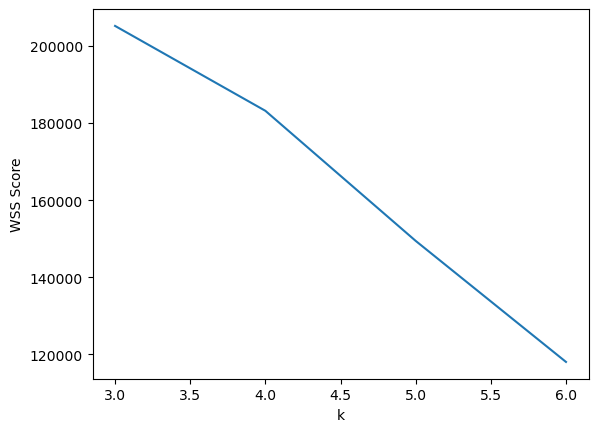

In [26]:
# Ahora se graficarán los WSS obtenidos para obtener lo que se conoce como diagrama de codo
plt.plot(range(3,7), score_wss)
plt.xlabel('k')
plt.ylabel('WSS Score')
plt.show()

In [27]:
# Seleccionamos como número de cluster óptimo al 4 y se vuelve a ejecutar el algoritmo k-means
kmeans = KMeans(featuresCol = 'explicativas_numericas_vector_escaladas', k = 4)
modelo = kmeans.fit(train)
clusters = modelo.transform(train)

In [28]:
# Finalmente, se obtienene los centroides de cada clúster
centros = modelo.clusterCenters()
print("Centros de los clústers: ")
for centro in centros:
    print(centro)

Centros de los clústers: 
[-0.46769285 -0.23736963 -0.01655109 -0.07720134]
[  1.69737229  -0.3191293  102.8476016  138.48149998]
[ 0.72042521  0.02200374 13.99131232 13.26825468]
[ 1.37011238  0.69858437 -0.08421027  0.0994372 ]
